In [1]:
# Importing all the necessary libraries
import keras
import h5py
from keras import optimizers
from keras.models import load_model
from keras.layers import Bidirectional
from Multimodal_baseline_Functions import *
from keras.layers.core import Reshape, Dropout
from keras.utils.vis_utils import plot_model
import os
# import keras_metrics
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling3D
from keras import regularizers
# import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.metrics import confusion_matrix
from keras import regularizers  
from keras.applications.inception_v3 import InceptionV3

In [2]:
# Storing directory of glove embeddings
GLOVE_DIR = "C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\glove.6B"
EMBEDDING_DIM = 50

In [3]:
# Assigning class weights
class_weight = {1: 1.4,
                0: 1.}

In [4]:
# Defining model with Adam optimizer
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\optimizers\optimizer_v2\adadelta.py:82: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [5]:
def Image_model(base_model):
    # Freezing all the trainable layers
    for layer in base_model.layers:
        layer.trainable = False

    # Creating output layer
    x = base_model.output
    # Adding pooling layer before the output
    x = GlobalAveragePooling2D()(x)
    return x

In [6]:
def read_data(file_name):
  #Opening file
    with open(file_name,'r', encoding="utf8") as f:
      #Creating empty set and dictonary for vocab and word respectively
        word_vocab = set() 
        word2vector = {}
        #Iterating over each line of file
        for line in f:
            #Spliting lines
            line_ = line.strip() 
            #Splitting words
            words_Vec = line_.split()            
            word_vocab.add(words_Vec[0])
            word2vector[words_Vec[0]] = np.array(words_Vec[1:],dtype=float)
    print("Total Words in DataSet:",len(word_vocab))
    return word_vocab,word2vector

In [7]:
# Dividing data in test, train, validation
training_DF, testing_DF, validation_DF = preprocess_text(Training_path,Validation_path, Testing_path)

In [8]:
# Processing image and text for each set
# Creating train, test and validation image path
train_img_path = create_img_path(training_DF,'image_name', img_dir)
test_img_path = create_img_path(testing_DF,'image_name', img_dir)
val_img_path = create_img_path(validation_DF,'image_name', img_dir)

# Processing the text
training_DF['sentence'] = training_DF['sentence'].apply(clean_text)
testing_DF['sentence'] = testing_DF['sentence'].apply(clean_text)
validation_DF['sentence'] = validation_DF['sentence'].apply(clean_text)

In [9]:
from keras.utils import pad_sequences

In [36]:
# Vectorising text
# process the whole observation into single list
train_text_list=list(training_DF['sentence'])
test_text_list = list(testing_DF['sentence'])
val_text_list = list(validation_DF['sentence'])

# Creating vectors for train, test, validation
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(train_text_list)
sequences_train = tokenizer.texts_to_sequences(train_text_list)
sequences_test = tokenizer.texts_to_sequences(test_text_list)
sequences_val = tokenizer.texts_to_sequences(val_text_list)

x_train = pad_sequences(sequences_train, maxlen=1000)
x_test = pad_sequences(sequences_test, maxlen=1000)
x_val = pad_sequences(sequences_val, maxlen=1000)

# encoding all the labels 
y_test = testing_DF['label']
y_train = training_DF['label']
y_val = validation_DF['label']

In [37]:
from transformers import BertTokenizer

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize your text data (x_train) and create attention masks
def tokenize_text(text_data, maxlen=512):
    inputs = tokenizer(text_data, padding="max_length", truncation=True, max_length=maxlen, return_tensors='np')
    return inputs['input_ids'], inputs['attention_mask']


In [38]:
input_ids_train, attention_mask_train = tokenize_text(train_text_list, maxlen=512)
input_ids_test, attention_mask_test = tokenize_text(test_text_list, maxlen=512)
input_ids_val, attention_mask_val = tokenize_text(val_text_list, maxlen=512)

In [39]:
img_txt_gen_train2 = img_text_generator2(train_img_path, input_ids_train, attention_mask_train, y_train, batch_size=32)
img_txt_gen_test2 = img_text_generator2(test_img_path, input_ids_test, attention_mask_test, y_test, batch_size=1)
img_txt_gen_val2 = img_text_generator2(val_img_path, input_ids_val, attention_mask_val, y_val, batch_size=1)

In [40]:
batch_x, batch_y = next(img_txt_gen_train2)

# Check the shape of the inputs (both image and text inputs)
image_input_shape = batch_x[0].shape  # Shape of image input
text_input_shape = batch_x[1].shape   # Shape of text input
att = batch_x[2].shape 

# Check the shape of the labels
labels_shape = batch_y.shape

# Print the shapes
print("Image input shape:", image_input_shape)
print("Text input shape:", text_input_shape)
print("attension mask shae: ", att)
print("Labels shape:", labels_shape)

Image input shape: (32, 224, 224, 3)
Text input shape: (32, 512)
attension mask shae:  (32, 512)
Labels shape: (32,)


In [14]:
# Creating train, test, val, generator for meme (gives -> {image,text in image, O/NO} )
img_txt_gen_train = img_text_generator(train_img_path, x_train, y_train, batch_size=32)
img_txt_gen_test = img_text_generator(test_img_path, x_test, y_test, batch_size=1)
img_txt_gen_val = img_text_generator(val_img_path, x_val, y_val, batch_size=1)

# Creating train, test, val, generator for text (gives -> {text in image, O/NO})
txt_gen_train = text_generator(x_train, y_train, batch_size=32)
txt_gen_test = text_generator(x_test, y_test, batch_size=1)
txt_gen_val = text_generator(x_val, y_val, batch_size=1)

# Creating train, test, val, generator for image (gives -> {image, O/NO})
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
img_gen_test = image_generator(test_img_path, testing_DF, batch_size=1)
img_gen_val = image_generator(val_img_path, validation_DF, batch_size=1)

In [12]:
import keras.utils as image

<generator object image_generator at 0x000002528BAE2148>

In [13]:
print(len(train_img_path))

445


In [22]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array

In [15]:
# Test the generator manually
img_gen_train = image_generator(train_img_path, training_DF, batch_size=32)
batch_x, batch_y = next(img_gen_train)
print(batch_x.shape, batch_y.shape)  # Check if it produces the expected shapes

(32, 224, 224, 3) (32,)


In [17]:
print(train_img_path[:5])  # Print first 5 image paths
print(training_DF.head())   # Check the first few rows of the DataFrame

['C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Labelled Images\\LJ3r8Gy.jpg.png', 'C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Labelled Images\\qDnIIHA.png', 'C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Labelled Images\\1JQk5NF.png', 'C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Labelled Images\\iMMNq.png', 'C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Labelled Images\\jAi3iI1.png']
        image_name                                           sentence  label
0  LJ3r8Gy.jpg.png  official bernie sanders drinking game every ti...      0
1      qDnIIHA.png  228 pm wall inside nazi gas chamber dwebs demo...      1
2      1JQk5NF.png                     shit waddup bernie sanders com      1
3        iMMNq.png  mitt romney worst republican country putup bar...      0
4      jAi3iI1.png  anonymous id duqda1io 08 05 16 fri 163248 8423...      0


In [16]:
for i in range(5):  # Fetch 5 batches manually
    batch_x, batch_y = next(img_gen_train)
    print(batch_x.shape, batch_y.shape)

(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)
(32, 224, 224, 3) (32,)


In [13]:
# Creating vocabulary with glove embeddings
vocab, w2v = read_data(os.path.join(GLOVE_DIR, "glove.6B.50d.txt"))

Total Words in DataSet: 400000


In [14]:
# Creating word index
word_index = tokenizer.word_index
num_tokens = len(word_index)

In [15]:
#Creating embeddding weight matrix
embedding_matrix = np.zeros((num_tokens + 1, EMBEDDING_DIM))

for word, i in word_index.items():
    embedding_vector = w2v.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
#Creating embedded layer using embedded matrix as weight matrix
embedding_layer = Embedding(num_tokens + 1, EMBEDDING_DIM, weights=[embedding_matrix], trainable = False)

In [18]:
from keras.layers import Input

In [19]:
# Defining input layer
main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')

# Defining embedding layer which will encode the input sequence
embedded_sequences = embedding_layer(main_input)

In [ ]:


# # A LSTM will transform the vector sequence into a single vector,
# # containing information about the entire sequence
# lstm1 = LSTM(32, return_state=True)
# encoder_outputs,state_h,state_c = (lstm1)(embedded_sequences)
# states= [state_h,state_c]

W1109 01:05:03.298506  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1109 01:05:03.305695  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1109 01:05:03.348326  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1109 01:05:03.350874  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [ ]:
# # Defining second LSTM
# lstm2=LSTM(32, return_sequences=True, return_state=True)
# # Adding initial state as state of  previous LSTM
# decoder_out,_,_=lstm2(embedded_sequences,initial_state=states)
# # Adding dense layer with 500 neurons
# decoder_dense = (Dense(500, activation='relu'))
# # LSTM output
# lstm_out=(decoder_out)
# # Flattening 
# lstm_out = Flatten()(lstm_out)
# # Output of text model
# txt_out = Dense(1, activation='sigmoid')(lstm_out)

In [17]:
# # Defining text model
# txt_model = Model(inputs = [main_input], outputs=txt_out)

NameError: name 'txt_out' is not defined

In [16]:
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout, GlobalAveragePooling2D, Embedding, concatenate
from keras.applications import ResNet50
from keras.layers import Embedding

In [17]:
# Image Input and CNN
image_input = Input(shape=(224, 224, 3), name='image_input')
base_cnn = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)
cnn_out = GlobalAveragePooling2D(name='globalavg_05')(base_cnn.output)
cnn_out = Dense(128, activation='relu', name='dense_05')(cnn_out)
img_prediction_layer = Dense(1, activation='sigmoid', name='dense_06')(cnn_out)
# pre_trained_image_model = VGG16(weights='imagenet', include_top=False)
img_model = Model(inputs = [base_cnn.input], outputs=img_prediction_layer)
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])


In [59]:
img_gen_train.input

AttributeError: 'generator' object has no attribute 'input'

In [57]:
np.array(img_gen_train).shape

()

In [77]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
import keras.utils as image

In [78]:
next(img_gen_train)

StopIteration: 

In [18]:
img_model.fit_generator(img_gen_train,
                        epochs=4,
                        validation_steps = len(x_val)//32,
                        steps_per_epoch=len(x_train)//32, 
                        validation_data=img_gen_val, 
                        shuffle=False, 
                        class_weight=class_weight)

c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/4
13/13 [==============================] - 93s 7s/step - loss: 0.0814 - accuracy: 0.9591 - val_loss: 1.9853 - val_accuracy: 0.0000e+00
Epoch 2/4
13/13 [==============================] - 88s 7s/step - loss: 3.6094e-05 - accuracy: 1.0000 - val_loss: 51.1107 - val_accuracy: 0.0000e+00
Epoch 3/4
13/13 [==============================] - 88s 7s/step - loss: 9.1995e-06 - accuracy: 1.0000 - val_loss: 63.5904 - val_accuracy: 0.0000e+00
Epoch 4/4
13/13 [==============================] - 87s 7s/step - loss: 2.6104e-06 - accuracy: 1.0000 - val_loss: 57.3965 - val_accuracy: 0.0000e+00


In [19]:
img_model.save('image_model_1.00ac.h5')

In [13]:
from keras.models import load_model

# Load the model into the img_model variable
img_model = load_model('image_model_1.00ac.h5')

W1127 23:11:38.967010  7512 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1127 23:11:39.007158  7512 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1127 23:11:39.029636  7512 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1127 23:11:39.030635  7512 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is de

In [19]:
maxlen = 512

In [32]:
print(train_text_list)

['official bernie sanders drinking game every time bernster mentions free government program chug somebody else beer', '228 pm wall inside nazi gas chamber dwebs democrat mentions gun control remember picture', 'shit waddup bernie sanders com', 'mitt romney worst republican country putup barack obama endorse mitt romney', 'anonymous id duqda1io 08 05 16 fri 163248 84231555 84231620 84231654 84231659 84231689 84231698 2 84231735 84231790 84231867 84231910 84232021 84232120 84232180 84232228 84232342 84232377 84232671 84232765 84232970 file image jpg 92 kb 740547 repeating digits pass away getting witness trump vs hillary debate', 'kle watching dem debate hell yeah bernie hillary avoiding questions stahp hillary fucking stop swear fucking god hillary answer god damn question stop avoiding topic actually fucking debate ali', 'trump isanasshole hillary isaliar iiwishicould vote negroagain', 'nt cop problem america problem cops sure black america cop problem cops neighborhood neighborhood l

In [36]:
training_DF["sentence"] = training_DF["sentence"].apply(clean_text)

In [41]:
max(training_DF["sentence"].apply(len))

1066

In [ ]:
train_text_list = train_text_list.

In [42]:
lent = 0
for i in train_text_list:
    l = len(i)
    lent = max(lent,l)
print(lent)

1066


In [22]:
from transformers import TFBertModel
from keras.layers import GlobalAveragePooling1D
import tensorflow as tf

c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
from keras.layers import Dense, Dropout, GlobalAveragePooling1D
from keras.models import Model


In [43]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')
input_ids = Input(shape=(maxlen,), dtype=tf.int32, name="input_ids")
attention_mask = Input(shape=(maxlen,), dtype=tf.int32, name="attention_mask")

bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
pooled_output = GlobalAveragePooling1D()(bert_output)
dense_out = Dense(128, activation='relu')(pooled_output)
dropout_out = Dropout(0.3)(dense_out)
output = Dense(1, activation='sigmoid')(dropout_out)

model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jasra\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transfor

In [44]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [45]:
print(f"Model call method: {model.call}")

Model call method: <bound method Functional.call of <keras.engine.functional.Functional object at 0x000002B1A04EF908>>


In [46]:
from transformers import BertTokenizer
import numpy as np

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and encode text
def encode_texts(texts, tokenizer, maxlen):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maxlen,
            pad_to_max_length=True,
            return_attention_mask=True,
            truncation=True
        )
        input_ids.append(encoding['input_ids'])
        attention_masks.append(encoding['attention_mask'])
    return np.array(input_ids), np.array(attention_masks)

In [47]:
print(np.array(y_train))

[0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1
 0 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0
 1 1 0 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1
 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0
 1 0 1 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 0 0 1 0
 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1
 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 0 0 1 1 0 0 1
 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1
 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1
 1]


In [48]:
input_ids_train, attention_masks_train = encode_texts(train_text_list, tokenizer, maxlen)
input_ids_val, attention_masks_val = encode_texts(val_text_list, tokenizer, maxlen)

# Convert labels to numpy arrays
labels_train = np.array(y_train)
labels_val = np.array(y_val)

c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2383: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [49]:
print(attention_masks_train)

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [50]:
print(f"input_ids_train shape: {np.array(input_ids_train).shape}")
print(f"input_ids_val shape: {np.array(input_ids_val).shape}")
print(f"labels_train shape: {np.array(labels_train).shape}")
print(f"labels_val shape: {np.array(labels_val).shape}")

input_ids_train shape: (445, 512)
input_ids_val shape: (149, 512)
labels_train shape: (445,)
labels_val shape: (149,)


In [51]:
print(f"Model input names: {model.input_names}")
print(f"Model output names: {model.output_names}")

Model input names: ['input_ids', 'attention_mask']
Model output names: ['dense_1']


In [52]:
bert_model.trainable = True

In [53]:
history = model.fit(
    x=[input_ids_train, attention_masks_train],  # Training data
    y=labels_train,                              # Training labels
    validation_data=([input_ids_val, attention_masks_val], labels_val),  # Validation data
    batch_size=8,  # Reduce from 32 to 8 or even 4
    epochs=4,
    steps_per_epoch=len(input_ids_train) // 8,
    validation_steps=len(input_ids_val) // 8
)

Epoch 1/4
55/55 [==============================] - 1103s 20s/step - loss: 0.8888 - accuracy: 0.5409 - val_loss: 0.6837 - val_accuracy: 0.6181
Epoch 2/4
55/55 [==============================] - 1028s 19s/step - loss: 0.7132 - accuracy: 0.5332 - val_loss: 0.6652 - val_accuracy: 0.6181
Epoch 3/4
55/55 [==============================] - 1009s 18s/step - loss: 0.6774 - accuracy: 0.5789 - val_loss: 0.6852 - val_accuracy: 0.6181
Epoch 4/4
55/55 [==============================] - 1011s 18s/step - loss: 0.6920 - accuracy: 0.5744 - val_loss: 0.6817 - val_accuracy: 0.6181


In [54]:
model.save('bertText_model_57%ac.h5')

In [24]:
from tensorflow.keras.models import load_model

In [21]:
import tensorflow as tf

In [22]:
from tensorflow.keras.models import load_model
from transformers import TFBertModel

# Load the model with the custom object scope for TFBertModel
with tf.keras.utils.custom_object_scope({'TFBertModel': TFBertModel}):
    txt_model = load_model('bertText_model_57%ac.h5')

In [23]:
img_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['image_input[0][0]']            
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [32]:
model.fit_generator(
    [input_ids_train, attention_masks_train],  # Inputs
    labels_train,                              # Labels
    validation_data=([input_ids_val, attention_masks_val], labels_val),
                         epochs=7, 
                         validation_steps = len(x_val)//32, 
                         steps_per_epoch=len(x_train)//32, 
                         shuffle = False, 
                         class_weight=class_weight)

/home/jsehmbey/Desktop/btech_final_year_project/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [34]:
# # Text Input and LSTM
# text_input = Input(shape=(maxlen,), dtype='int32', name='text_input')
# embedded_text = embedding_layer(text_input)
# lstm_out = LSTM(32)(embedded_text)/

from keras.layers import Input, LSTM, Bidirectional, Dropout, Dense, Embedding
from keras.layers import Activation, Dot
from keras.models import Model

# Text Input
text_input = Input(shape=(maxlen,), dtype='int32', name='text_input')

# Embedding Layer (using pre-trained GloVe embeddings)
embedded_text = embedding_layer(text_input)

# Bidirectional LSTM Layer
lstm_out = Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(embedded_text)

# Attention Mechanism
attention = Dense(1, activation='tanh')(lstm_out)
attention = Flatten()(attention)
attention_weights = Activation('softmax')(attention)
context_vector = Dot(axes=1)([lstm_out, attention_weights])

# Fully Connected Layer with Batch Normalization
dense_out = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(context_vector)
dense_out = Dropout(0.3)(dense_out)

# Final Output Layer
output = Dense(1, activation='sigmoid')(dense_out)

# Define the Model
text_model = Model(inputs=text_input, outputs=output)

# Compile the Model
text_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
text_model.summary()


W1127 19:23:33.542382 12592 deprecation.py:506] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 50)     219000      text_input[0][0]                 
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 1000, 128)    58880       embedding_1[0][0]                
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 1000, 1)      129         bidirectional_1[0][0]            
__________________________________________________________________________________________________
flatten_1 

In [35]:
# Training text model
text_model.fit_generator(txt_gen_train, 
                         epochs=7, 
                         validation_steps = len(x_val)//32, 
                         steps_per_epoch=len(x_train)//32, 
                         validation_data=txt_gen_val, 
                         shuffle = False, 
                         class_weight=class_weight)

Epoch 1/7
13/13 [==============================] - 13s 968ms/step - loss: 1.9190 - acc: 0.5168 - val_loss: 1.6554 - val_acc: 0.5000
Epoch 2/7
13/13 [==============================] - 9s 681ms/step - loss: 1.6520 - acc: 0.5962 - val_loss: 1.4093 - val_acc: 0.7500
Epoch 3/7
13/13 [==============================] - 9s 707ms/step - loss: 1.4400 - acc: 0.5986 - val_loss: 1.2347 - val_acc: 0.5000
Epoch 4/7
13/13 [==============================] - 9s 728ms/step - loss: 1.2775 - acc: 0.5986 - val_loss: 1.0947 - val_acc: 0.5000
Epoch 5/7
13/13 [==============================] - 10s 737ms/step - loss: 1.1525 - acc: 0.5986 - val_loss: 0.9717 - val_acc: 0.7500
Epoch 6/7
13/13 [==============================] - 10s 754ms/step - loss: 1.0590 - acc: 0.5913 - val_loss: 0.9052 - val_acc: 0.5000
Epoch 7/7
13/13 [==============================] - 10s 765ms/step - loss: 0.9887 - acc: 0.5962 - val_loss: 0.8356 - val_acc: 0.7500


In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate, Dense, Dropout
from tensorflow.keras import optimizers

# Assuming txt_model and img_model are already defined

# Concatenate the outputs of both models
con_layer = concatenate([txt_model.output, img_model.output], name="concatenated_layer")

# Add dense, dropout, and output layers with unique names
dense_1 = Dense(64, activation='relu', name='d')(con_layer)
dropout_1 = Dropout(0.3, name='drop')(dense_1)
output_layer = Dense(1, activation='sigmoid', name='o')(dropout_1)

# Create the final model with unique layer names
com_model = Model(inputs=[img_model.input, txt_model.input], outputs=output_layer)

# Use the Adam optimizer
adam = optimizers.Adam(lr=0.001)

# Compile the model
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=["accuracy"])


In [42]:
img_model.input.shape

TensorShape([None, 224, 224, 3])

In [43]:
txt_model.input

[<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_ids')>,
 <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'attention_mask')>]

In [44]:
batch_x, batch_y = next(img_txt_gen_train2)

# Check the shape of the inputs (both image and text inputs)
image_input_shape = batch_x[0].shape  # Shape of image input
text_input_shape = batch_x[1].shape   # Shape of text input
att = batch_x[2].shape 

# Check the shape of the labels
labels_shape = batch_y.shape

# Print the shapes
print("Image input shape:", image_input_shape)
print("Text input shape:", text_input_shape)
print("attension mask shae: ", att)
print("Labels shape:", labels_shape)

Image input shape: (32, 224, 224, 3)
Text input shape: (32, 512)
attension mask shae:  (32, 512)
Labels shape: (32,)


In [35]:
print(com_model.input)

[<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'image_input')>, [<KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'input_ids')>, <KerasTensor: shape=(None, 512) dtype=int32 (created by layer 'attention_mask')>]]


In [50]:
attention_mask = Input(shape=(512,), dtype=tf.int32, name="attention_mask")

In [27]:
con_layer = concatenate([txt_model.output, img_model.output])
dense = Dense(64, activation='relu')(con_layer)
dropout = Dropout(0.3)(dense)
out = Dense(1, activation='sigmoid')(dropout)
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

ValueError: The name "dense" is used 2 times in the model. All layer names should be unique.

In [30]:
class_weight = {1: 1.4,
                0: 1.}

In [ ]:
# Training
com_model.fit_generator(
    img_txt_gen_train2,
    validation_data=img_txt_gen_val2,
    steps_per_epoch=len(x_train)//8,
    validation_steps=len(x_val)//8,
    epochs=4,
    class_weight=class_weight
)

c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/4


 1/55 [..............................] - ETA: 5:02:07 - loss: 0.8189 - accuracy: 0.5312

In [38]:
com_model.save('newfinal_model_ac.h5')

In [ ]:
# # Fusion
# concat = concatenate([cnn_out, lstm_out])
# dense = Dense(64, activation='relu')(concat)
# dropout = Dropout(0.3)(dense)
# output = Dense(1, activation='sigmoid')(dropout)


W1126 22:47:14.102974 32732 deprecation.py:506] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [ ]:
# # Model
# multi_model = Model(inputs=[image_input, text_input], outputs=output)
# multi_model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])


W1126 22:47:25.526576 32732 deprecation_wrapper.py:119] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1126 22:47:25.534574 32732 deprecation.py:323] From c:\Users\jasra\OneDrive\Desktop\MAJOR PROJECT\.venv\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [24]:
# Training
multi_model.fit_generator(
    img_txt_gen_train,
    validation_data=img_txt_gen_val,
    steps_per_epoch=len(x_train)//32,
    validation_steps=len(x_val)//32,
    epochs=7,
    class_weight=class_weight
)

Epoch 1/7
13/13 [==============================] - 253s 19s/step - loss: 1.0125 - acc: 0.6298 - val_loss: 4.6548 - val_acc: 0.5000
Epoch 2/7
13/13 [==============================] - 242s 19s/step - loss: 0.9472 - acc: 0.6202 - val_loss: 0.7432 - val_acc: 0.2500
Epoch 3/7
13/13 [==============================] - 239s 18s/step - loss: 1.0405 - acc: 0.6058 - val_loss: 15.9424 - val_acc: 0.0000e+00
Epoch 4/7
13/13 [==============================] - 254s 20s/step - loss: 0.8717 - acc: 0.5264 - val_loss: 4.5536 - val_acc: 0.2500
Epoch 5/7
13/13 [==============================] - 236s 18s/step - loss: 0.8111 - acc: 0.6202 - val_loss: 0.8940 - val_acc: 0.2500
Epoch 6/7
13/13 [==============================] - 231s 18s/step - loss: 0.7633 - acc: 0.6418 - val_loss: 2.1085 - val_acc: 0.5000
Epoch 7/7
13/13 [==============================] - 229s 18s/step - loss: 0.8146 - acc: 0.6442 - val_loss: 0.8201 - val_acc: 0.2500


In [ ]:
# Saving text modelSS
multi_model.save('final_model_0.6442ac.h5')

In [26]:
# Predicting labels of the test set
y_pred_com = (multi_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))
# Defining true labels
y_true = y_test.values

In [39]:
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

NameError: name 'y_true' is not defined

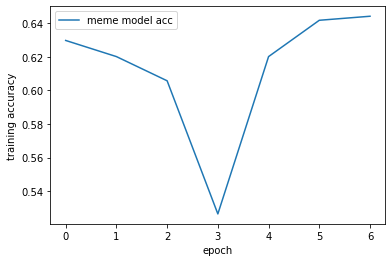

In [28]:
# Plotting training accuaracy 
plt.plot(multi_model.history.epoch, multi_model.history.history['acc'])
plt.gca().legend(('meme model acc', 'image model acc'))
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

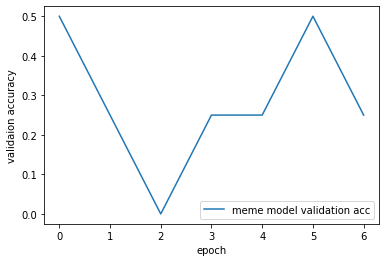

In [29]:

# Plotting validation accuracy
plt.plot(multi_model.history.epoch, multi_model.history.history['val_acc'])
plt.gca().legend(('meme model validation acc', 'image model validation acc'))
plt.xlabel('epoch')
plt.ylabel('validaion accuracy')
plt.show()

In [30]:
# Evaluating model by calculating loss and accuracy respectively
# for combined model
multi_model.evaluate_generator(img_txt_gen_test, steps=5)

[0.7797344565391541, 0.2]

In [ ]:
# # compiling text model
# txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

W1109 01:05:09.906090  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1109 01:05:09.913822  5476 deprecation.py:323] From d:\anaconda\envs\btechproject\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [20]:
# Training text model
txt_model.fit_generator(txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=txt_gen_val, shuffle = False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 19s 10s/step - loss: 0.8202 - acc: 0.4062 - val_loss: 0.7049 - val_acc: 0.4362
Epoch 2/7
2/2 [==============================] - 15s 7s/step - loss: 0.8100 - acc: 0.3750 - val_loss: 0.6913 - val_acc: 0.5436
Epoch 3/7
2/2 [==============================] - 15s 7s/step - loss: 0.7646 - acc: 0.6562 - val_loss: 0.6721 - val_acc: 0.6107
Epoch 4/7
2/2 [==============================] - 15s 7s/step - loss: 0.8411 - acc: 0.5625 - val_loss: 0.6731 - val_acc: 0.6107
Epoch 5/7
2/2 [==============================] - 15s 8s/step - loss: 0.8215 - acc: 0.5781 - val_loss: 0.6796 - val_acc: 0.6107
Epoch 6/7
2/2 [==============================] - 15s 7s/step - loss: 0.8039 - acc: 0.5781 - val_loss: 0.6876 - val_acc: 0.5973
Epoch 7/7
2/2 [==============================] - 15s 7s/step - loss: 0.8284 - acc: 0.6094 - val_loss: 0.7037 - val_acc: 0.4362


In [21]:
# Saving text model
txt_model.save('Stack_LSTM_txt_model.h5')

d:\anaconda\envs\btechproject\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [22]:
# Predicting labels of the test set
y_pred_txt = (txt_model.predict_generator(txt_gen_test,steps = 149))
y_pred_txt = np.round(list(itertools.chain(*y_pred_txt)))
# Defining true labels
y_true = y_test.values

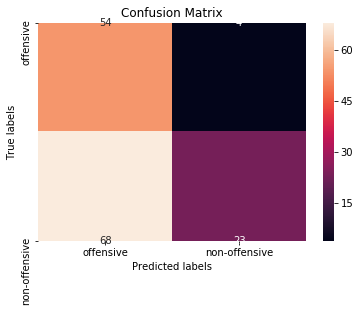

In [23]:
# Block that prints confusion matrix
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_txt, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [24]:
# create base model with imagenet weights
pre_trained_image_model = VGG16(weights='imagenet', include_top=False)

W1109 01:07:52.340348  5476 deprecation_wrapper.py:119] From d:\anaconda\envs\btechproject\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [25]:
# Building img_prediction layer using Image_model
base_img = Image_model(pre_trained_image_model)
img_prediction_layer = Dense(1, activation='sigmoid')(base_img)

In [26]:
# Defining image model
img_model = Model(inputs = [pre_trained_image_model.input], outputs=img_prediction_layer)

In [ ]:
# Compiling image model
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [28]:
# Plotting image model
plot_model(img_model, to_file='VGG16_img_model.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [ ]:
# Training image model
img_model.fit_generator(img_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_gen_val, shuffle=False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 33s 16s/step - loss: 2.8248 - acc: 0.5156 - val_loss: 0.1308 - val_acc: 1.0000
Epoch 2/7
2/2 [==============================] - 27s 13s/step - loss: 2.4685 - acc: 0.4688 - val_loss: 0.7130 - val_acc: 0.0000e+00
Epoch 3/7
2/2 [==============================] - 26s 13s/step - loss: 2.1571 - acc: 0.4844 - val_loss: 1.9528 - val_acc: 0.0000e+00
Epoch 4/7
2/2 [==============================] - 27s 13s/step - loss: 1.9844 - acc: 0.5156 - val_loss: 2.7603 - val_acc: 0.0000e+00
Epoch 5/7
2/2 [==============================] - 26s 13s/step - loss: 1.8334 - acc: 0.5000 - val_loss: 2.7608 - val_acc: 0.0000e+00
Epoch 6/7
2/2 [==============================] - 26s 13s/step - loss: 1.6170 - acc: 0.5000 - val_loss: 2.1896 - val_acc: 0.0000e+00
Epoch 7/7
2/2 [==============================] - 26s 13s/step - loss: 1.3790 - acc: 0.6250 - val_loss: 1.4229 - val_acc: 0.0000e+00


In [30]:
# Saving image model
img_model.save('VGG16_img_model.h5')

In [31]:
# Predicting labels using image model
y_pred_img = (img_model.predict_generator(img_gen_test,steps = 149))
y_pred_img = np.round(list(itertools.chain(*y_pred_img)))
y_true = y_test.values

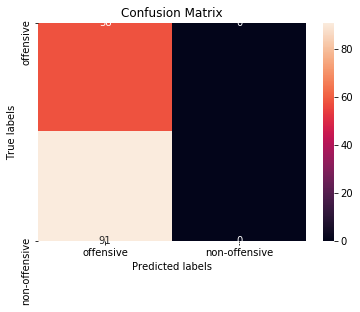

In [32]:
# Confusion matrix for image classifier
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_img, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

In [34]:
txt_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])
img_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [ ]:
# Concatenating output of both classifiers
con_layer = keras.layers.concatenate([txt_model.output, img_model.output])
out = Dense(1,activation='sigmoid')(con_layer)

In [36]:
# Defining model input and output
com_model = Model(inputs = [img_model.input, txt_model.input], outputs=out)

In [37]:
# Using Stochastic gradient descent with optimizer
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
com_model.compile(loss='binary_crossentropy', optimizer=adam, metrics = ["accuracy"])

In [38]:
# PlotTing combined model
plot_model(com_model, to_file='Stack_LSTM_VGG_mul_model.png', show_shapes=True, show_layer_names=True)

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [39]:
# Training model
com_model.fit_generator(img_txt_gen_train, epochs=7, validation_steps = 149, steps_per_epoch=2, validation_data=img_txt_gen_val, shuffle=False, class_weight=class_weight)

Epoch 1/7
2/2 [==============================] - 39s 20s/step - loss: 0.8184 - acc: 0.4688 - val_loss: 0.7067 - val_acc: 0.3691
Epoch 2/7
2/2 [==============================] - 36s 18s/step - loss: 0.7994 - acc: 0.3594 - val_loss: 0.7007 - val_acc: 0.4228
Epoch 3/7
2/2 [==============================] - 35s 17s/step - loss: 0.7911 - acc: 0.3125 - val_loss: 0.7056 - val_acc: 0.3356
Epoch 4/7
2/2 [==============================] - 36s 18s/step - loss: 0.7923 - acc: 0.3281 - val_loss: 0.7002 - val_acc: 0.3557
Epoch 5/7
2/2 [==============================] - 35s 18s/step - loss: 0.8252 - acc: 0.4844 - val_loss: 0.6957 - val_acc: 0.4295
Epoch 6/7
2/2 [==============================] - 35s 18s/step - loss: 0.8325 - acc: 0.5469 - val_loss: 0.6962 - val_acc: 0.4295
Epoch 7/7
2/2 [==============================] - 36s 18s/step - loss: 0.8165 - acc: 0.4531 - val_loss: 0.7004 - val_acc: 0.3557


In [40]:
# Saving combined model
com_model.save('Stack_LSTM_VGG_mul_model.h5')

d:\anaconda\envs\btechproject\lib\site-packages\keras\engine\network.py:877: UserWarning: Layer lstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_1/while/Exit_3:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'lstm_1/while/Exit_4:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [41]:
y_pred_com = (com_model.predict_generator(img_txt_gen_test,steps = 149))
y_pred_com = np.round(list(itertools.chain(*y_pred_com)))

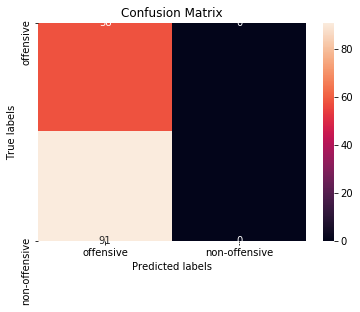

In [42]:
labels = [1,0]
cm = confusion_matrix(y_true, y_pred_com, labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['offensive', 'non-offensive']); ax.yaxis.set_ticklabels(['offensive', 'non-offensive']);

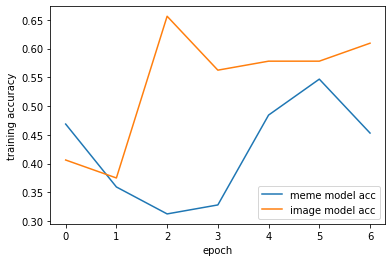

In [43]:
# Plotting training accuaracy 
plt.plot(com_model.history.epoch, com_model.history.history['acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['acc'])
plt.gca().legend(('meme model acc', 'image model acc', 'text model acc'))
plt.xlabel('epoch')
plt.ylabel('training accuracy')
plt.show()

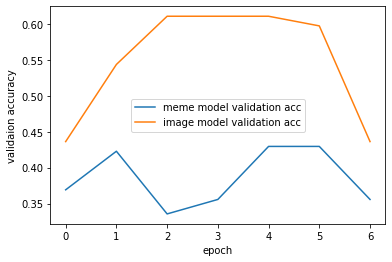

In [44]:

# Plotting validation accuracy
plt.plot(com_model.history.epoch, com_model.history.history['val_acc'])
plt.plot(txt_model.history.epoch, txt_model.history.history['val_acc'])
plt.gca().legend(('meme model validation acc', 'image model validation acc', 'text model validation acc'))
plt.xlabel('epoch')
plt.ylabel('validaion accuracy')
plt.show()

In [46]:
# Evaluating model by calculating loss and accuracy respectively
# for combined model
com_model.evaluate_generator(img_txt_gen_test, steps=5)

[0.6794470191001892, 0.8]

In [47]:
# loss and accuracy for text model
txt_model.evaluate_generator(txt_gen_test, steps=5)

[0.6761613667011261, 0.6]

In [48]:
# Loss and accuracy for image model
img_model.evaluate_generator(img_gen_test, steps=5)

[0.023184871301054955, 1.0]

In [49]:
from sklearn.metrics import precision_recall_fscore_support

In [50]:
# for txt
precision_recall_fscore_support(y_true, y_pred_txt, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.85185185, 0.44262295]),
 array([0.25274725, 0.93103448]),
 array([0.38983051, 0.6       ]),
 array([91, 58], dtype=int64))

In [51]:
# for image
precision_recall_fscore_support(y_true, y_pred_img, beta=1.0, labels=None, pos_label=1, average=None)

d:\anaconda\envs\btechproject\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([0.        , 0.38926174]),
 array([0., 1.]),
 array([0.        , 0.56038647]),
 array([91, 58], dtype=int64))

In [52]:
# com model
precision_recall_fscore_support(y_true, y_pred_com, beta=1.0, labels=None, pos_label=1, average=None)

(array([0.        , 0.38926174]),
 array([0., 1.]),
 array([0.        , 0.56038647]),
 array([91, 58], dtype=int64))